In [70]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from datetime import timedelta
# from IPython.display import clear_output

import gymnasium as gym
# from gymnasium.spaces import Box, Discrete

import torch
import torch.nn as nn

from ppo import PPOBuffer, PPOAgent

In [71]:
class Config(object):
    def __init__(self):
        pass

config = Config()
config.capacity = 4              # capacity of the buffer (the number of episodes in the buffer).
config.epochs = 50               # Number of epochs of interaction (equivalent to number of policy updates) to perform.
config.gamma = 0.99              # Discount factor.
config.clip_ratio = 0.2          # Hyperparameter for clipping in the policy objective. Roughly: how far can the new policy go from the old policy while still profiting (improving the objective function)? The new policy can still go farther than the clip_ratio says, but it doesn't help on the objective anymore. (Usually small, 0.1 to 0.3.)
config.actor_lr = 3e-4           # Learning rate for policy optimizer.
config.critic_lr = 1e-3          # Learning rate for value function optimizer.
config.train_actor_iters = 80    # Maximum number of gradient descent steps to take on policy loss per epoch. (Early stopping may cause optimizer to take fewer than this.)
config.train_critic_iters = 80   # Number of gradient descent steps to take on value function per epoch.
config.lamda = 0.97              # Lambda for GAE-Lambda. (Always between 0 and 1, close to 1.)
config.max_ep_len = 1000         # Maximum length of trajectory / episode / rollout.
config.target_kl = 0.01          # Roughly what KL divergence we think is appropriate between new and old policies after an update. This will get used for early stopping. (Usually small, 0.01 or 0.05.)
config.save_freq = 10            # How often (in terms of gap between epochs) to save the current policy and value function.
config.actor_hiddens = (64, 64)  # network architecture for actor.
config.critic_hiddens = (64, 64) # network architecture for critic.
config.activation = nn.Tanh      # activation function for actor and critic.
config.use_gae = True            # whether use GAE-lambda for advantage estimation

# Training

In [75]:
# ======================= training Loop ====================================
start = timer()

seed = 6 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


running_returns = []   
env_name = 'HalfCheetah-v4'    
env = gym.make(env_name)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

is_discrete = False       # whether action space is discrete

ppo_agent = PPOAgent(obs_dim, action_dim, is_discrete=is_discrete, config=config)
buffer = PPOBuffer(config.capacity, config.use_gae, config.gamma, config.lamda)

running_returns = []
# running_episode = 0

for epoch in range(config.epochs):
    for ep in range(config.capacity):        
        obs, info = env.reset(seed=seed)
        ep_return, ep_len = 0, 0
        for step in range(config.max_ep_len):
            # print('step')
            action, value, log_prob = ppo_agent.step(torch.as_tensor(obs, dtype=torch.float32))
            
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            ep_return += reward
            ep_len += 1
            
            buffer.add(obs, action, reward, log_prob, value)
            
            obs = next_obs
            
            if done:
                # if trajectory didn't reach terminal state, bootstrap value target
                if truncated:
                    _, last_val, _ = ppo_agent.step(torch.as_tensor(obs, dtype=torch.float32))
                else:
                    last_val = 0
                
                buffer.finish_path(last_val)
                    
#                 running_episode += 1
                running_returns.append(ep_return)
                print(f'epsiode return: {ep_return}, length: {ep_len}.')
                break
    
    ppo_agent.update(buffer, epoch)        
            
    # Save model
    if (epoch % config.save_freq == 0) or (epoch == config.epochs-1):
        ppo_agent.save(epoch)
        

print(timedelta(seconds=int(timer()-start)))

epsiode return: -383.92864764849696, length: 1000.
epsiode return: -320.12175250885764, length: 1000.
epsiode return: -229.645934923836, length: 1000.
epsiode return: -459.5877864779191, length: 1000.
Early stopping at step 67 due to reaching max kl.
============== epoch: 0 ================
actor loss: -0.053259555250406265, critic loss: 1013.1431274414062.
approx kl: 0.015072360634803772, entropy: 0.9115107655525208, clip ratio: 0.2447499930858612.
epsiode return: -286.16264802247366, length: 1000.
epsiode return: -304.9283085411872, length: 1000.
epsiode return: -325.9247853607306, length: 1000.
epsiode return: -195.14449908913085, length: 1000.
Early stopping at step 41 due to reaching max kl.
============== epoch: 1 ================
actor loss: -0.045473746955394745, critic loss: 380.232177734375.
approx kl: 0.015128199942409992, entropy: 0.9069880247116089, clip ratio: 0.23000000417232513.
epsiode return: -177.35877871968276, length: 1000.
epsiode return: -142.8924113731946, lengt

epsiode return: 38.619780763538095, length: 1000.
epsiode return: -116.95201197199465, length: 1000.
epsiode return: -59.67228687406426, length: 1000.
Early stopping at step 77 due to reaching max kl.
============== epoch: 18 ================
actor loss: -0.05868162587285042, critic loss: 128.2923583984375.
approx kl: 0.015068085864186287, entropy: 0.834657609462738, clip ratio: 0.2787500023841858.
epsiode return: -45.91883283177109, length: 1000.
epsiode return: -70.45206348380175, length: 1000.
epsiode return: -16.15602801539243, length: 1000.
epsiode return: -113.94736106816725, length: 1000.
Early stopping at step 34 due to reaching max kl.
============== epoch: 19 ================
actor loss: -0.04504355043172836, critic loss: 104.59254455566406.
approx kl: 0.0151553088799119, entropy: 0.8263050317764282, clip ratio: 0.22474999725818634.
epsiode return: -115.2471816658537, length: 1000.
epsiode return: -104.12106349935655, length: 1000.
epsiode return: 46.726008770300986, length: 

epsiode return: 119.45309804134902, length: 1000.
epsiode return: 230.7884334082621, length: 1000.
epsiode return: 115.82912280486661, length: 1000.
epsiode return: 166.52256555587732, length: 1000.
Early stopping at step 64 due to reaching max kl.
============== epoch: 37 ================
actor loss: -0.061445631086826324, critic loss: 199.25985717773438.
approx kl: 0.01504378393292427, entropy: 0.7463836073875427, clip ratio: 0.3087500035762787.
epsiode return: 327.02373738686777, length: 1000.
epsiode return: 315.6304360498672, length: 1000.
epsiode return: 219.0755251053359, length: 1000.
epsiode return: 185.43491907900298, length: 1000.
Early stopping at step 6 due to reaching max kl.
============== epoch: 38 ================
actor loss: -0.01324252225458622, critic loss: 121.19317626953125.
approx kl: 0.016588622704148293, entropy: 0.745758056640625, clip ratio: 0.2515000104904175.
epsiode return: 109.69051455049538, length: 1000.
epsiode return: 187.18371245344275, length: 1000.

Text(0.5, 1.0, 'Episode return')

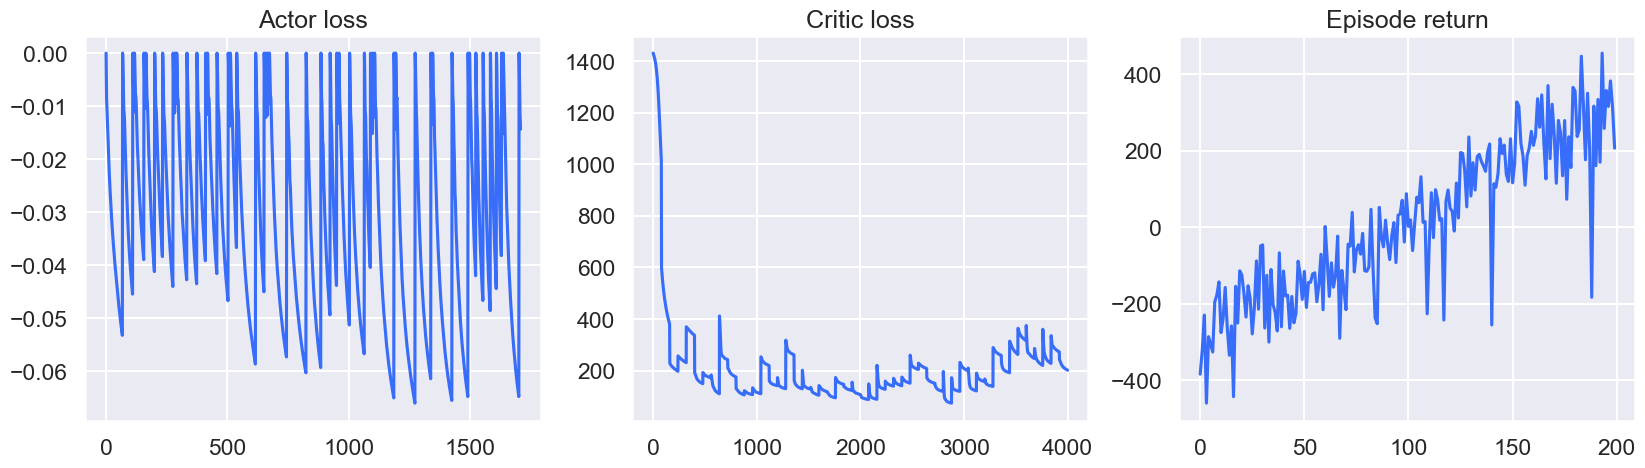

In [76]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(ppo_agent.actor_losses)
plt.title('Actor loss')
plt.subplot(132)
plt.plot(ppo_agent.critic_losses)
plt.title('Critic loss')
plt.subplot(133)
plt.plot(running_returns)
plt.title('Episode return')

# run different seeds

In [80]:
# ======================= training Loop ====================================
start = timer()

env_name = 'HalfCheetah-v4'    
env = gym.make(env_name)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

is_discrete = False       # whether action space is discrete

returns_over_seeds = []
for seed in [1, 2, 3, 5, 8]:
    print(f'========== random seed: {seed} is running. ===========')
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    ppo_agent = PPOAgent(obs_dim, action_dim, is_discrete=is_discrete, config=config)
    buffer = PPOBuffer(config.capacity, config.use_gae, config.gamma, config.lamda)

    returns_over_episodes = []
    for epoch in range(config.epochs):
        for ep in range(config.capacity):        
            obs, info = env.reset(seed=seed)
            ep_return, ep_len = 0, 0
            for step in range(config.max_ep_len):
                # print('step')
                action, value, log_prob = ppo_agent.step(torch.as_tensor(obs, dtype=torch.float32))

                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                ep_return += reward
                ep_len += 1

                buffer.add(obs, action, reward, log_prob, value)

                obs = next_obs

                if done:
                    # if trajectory didn't reach terminal state, bootstrap value target
                    if truncated:
                        _, last_val, _ = ppo_agent.step(torch.as_tensor(obs, dtype=torch.float32))
                    else:
                        last_val = 0

                    buffer.finish_path(last_val)

                    returns_over_episodes.append(ep_return)
                    print(f'epsiode return: {ep_return}, length: {ep_len}.')
                    break

        ppo_agent.update(buffer, epoch)        
        
    returns_over_seeds.append(returns_over_episodes)
        
        
print(timedelta(seconds=int(timer()-start)))

========== random seed: 1 is running. ===========
epsiode return: -362.9131912484529, length: 1000.
epsiode return: -344.1641512650844, length: 1000.
epsiode return: -265.583033336457, length: 1000.
epsiode return: -316.63087009858526, length: 1000.
Early stopping at step 70 due to reaching max kl.
============== epoch: 0 ================
actor loss: -0.053234171122312546, critic loss: 712.2682495117188.
approx kl: 0.015018115751445293, entropy: 0.9086366891860962, clip ratio: 0.24025000631809235.
epsiode return: -268.1343679060069, length: 1000.
epsiode return: -288.24326048181274, length: 1000.
epsiode return: -403.0353083406174, length: 1000.
epsiode return: -273.0664552308036, length: 1000.
Early stopping at step 34 due to reaching max kl.
============== epoch: 1 ================
actor loss: -0.041287269443273544, critic loss: 353.3150939941406.
approx kl: 0.015378361567854881, entropy: 0.9001242518424988, clip ratio: 0.1822499930858612.
epsiode return: -358.045255884979, length: 1

epsiode return: -200.3738594573646, length: 1000.
epsiode return: -207.24334168422624, length: 1000.
epsiode return: -189.19003891040543, length: 1000.
epsiode return: -201.17430513586393, length: 1000.
Early stopping at step 7 due to reaching max kl.
============== epoch: 18 ================
actor loss: -0.012591669335961342, critic loss: 46.300743103027344.
approx kl: 0.0175563246011734, entropy: 0.8422584533691406, clip ratio: 0.23274999856948853.
epsiode return: -137.63503361062936, length: 1000.
epsiode return: -144.07799381858186, length: 1000.
epsiode return: -132.30344282031967, length: 1000.
epsiode return: -168.25605990290111, length: 1000.
Early stopping at step 6 due to reaching max kl.
============== epoch: 19 ================
actor loss: -0.010576367378234863, critic loss: 72.6258544921875.
approx kl: 0.01668955758213997, entropy: 0.8408616781234741, clip ratio: 0.23899999260902405.
epsiode return: -172.92873859930822, length: 1000.
epsiode return: -143.35649769349206, le

epsiode return: -137.4670816844115, length: 1000.
epsiode return: -126.20332199413652, length: 1000.
epsiode return: -80.65825196764474, length: 1000.
Early stopping at step 31 due to reaching max kl.
============== epoch: 36 ================
actor loss: -0.044025786221027374, critic loss: 42.20124053955078.
approx kl: 0.015123678371310234, entropy: 0.7778483033180237, clip ratio: 0.20724999904632568.
epsiode return: -105.45745340497217, length: 1000.
epsiode return: -45.74365998792788, length: 1000.
epsiode return: -7.472325121971881, length: 1000.
epsiode return: -60.06814920254087, length: 1000.
Early stopping at step 7 due to reaching max kl.
============== epoch: 37 ================
actor loss: -0.012657511979341507, critic loss: 68.83390045166016.
approx kl: 0.015195750631392002, entropy: 0.7771499156951904, clip ratio: 0.24549999833106995.
epsiode return: -80.1443886891623, length: 1000.
epsiode return: -18.08597470525866, length: 1000.
epsiode return: -132.79002138700895, lengt

epsiode return: -361.09047602402865, length: 1000.
Early stopping at step 47 due to reaching max kl.
============== epoch: 4 ================
actor loss: -0.04447667673230171, critic loss: 254.42747497558594.
approx kl: 0.015111614018678665, entropy: 0.8843700885772705, clip ratio: 0.21975000202655792.
epsiode return: -238.17473189247377, length: 1000.
epsiode return: -256.060390459676, length: 1000.
epsiode return: -253.58562944570963, length: 1000.
epsiode return: -373.1078023951153, length: 1000.
Early stopping at step 7 due to reaching max kl.
============== epoch: 5 ================
actor loss: -0.011050509288907051, critic loss: 229.42001342773438.
approx kl: 0.015731243416666985, entropy: 0.8827667832374573, clip ratio: 0.1602499932050705.
epsiode return: -213.03174546326858, length: 1000.
epsiode return: -246.5845362552022, length: 1000.
epsiode return: -316.7199868813717, length: 1000.
epsiode return: -246.7003635899074, length: 1000.
Early stopping at step 6 due to reaching m

Early stopping at step 71 due to reaching max kl.
============== epoch: 22 ================
actor loss: -0.05838583782315254, critic loss: 115.13578033447266.
approx kl: 0.015060185454785824, entropy: 0.8129007816314697, clip ratio: 0.26600000262260437.
epsiode return: -163.90355417206817, length: 1000.
epsiode return: -267.78047143167834, length: 1000.
epsiode return: -163.40930139237065, length: 1000.
epsiode return: -138.7130318580375, length: 1000.
Early stopping at step 7 due to reaching max kl.
============== epoch: 23 ================
actor loss: -0.012281595729291439, critic loss: 174.77932739257812.
approx kl: 0.015531491488218307, entropy: 0.8120549321174622, clip ratio: 0.24324999749660492.
epsiode return: -205.1087389352296, length: 1000.
epsiode return: -92.72874397994991, length: 1000.
epsiode return: -130.62930589990688, length: 1000.
epsiode return: -166.7432161609539, length: 1000.
Early stopping at step 6 due to reaching max kl.
============== epoch: 24 ==============

epsiode return: 22.934595701215464, length: 1000.
epsiode return: -15.57072938844922, length: 1000.
epsiode return: 5.767114600581864, length: 1000.
epsiode return: 46.00270959545654, length: 1000.
Early stopping at step 30 due to reaching max kl.
============== epoch: 41 ================
actor loss: -0.04521997272968292, critic loss: 87.72962188720703.
approx kl: 0.015140991657972336, entropy: 0.6985474228858948, clip ratio: 0.23600000143051147.
epsiode return: 55.651809133676466, length: 1000.
epsiode return: 130.14966785770366, length: 1000.
epsiode return: -8.915347947323031, length: 1000.
epsiode return: 28.54706225569994, length: 1000.
Early stopping at step 4 due to reaching max kl.
============== epoch: 42 ================
actor loss: -0.011822951957583427, critic loss: 56.41221618652344.
approx kl: 0.018018966540694237, entropy: 0.6972623467445374, clip ratio: 0.19300000369548798.
epsiode return: -21.055161533926576, length: 1000.
epsiode return: 39.323589094126035, length: 10

epsiode return: -256.81697523531557, length: 1000.
epsiode return: -142.2841010806053, length: 1000.
Early stopping at step 44 due to reaching max kl.
============== epoch: 9 ================
actor loss: -0.049677666276693344, critic loss: 77.1937255859375.
approx kl: 0.015068601816892624, entropy: 0.8794667720794678, clip ratio: 0.24375000596046448.
epsiode return: -202.6893516808655, length: 1000.
epsiode return: -369.0586719109881, length: 1000.
epsiode return: -220.93126173011117, length: 1000.
epsiode return: -188.9851920749397, length: 1000.
Early stopping at step 29 due to reaching max kl.
============== epoch: 10 ================
actor loss: -0.03910656273365021, critic loss: 111.19969940185547.
approx kl: 0.015032473020255566, entropy: 0.8738346099853516, clip ratio: 0.17550000548362732.
epsiode return: -214.18650567696713, length: 1000.
epsiode return: -160.98706715376466, length: 1000.
epsiode return: -265.57959896885876, length: 1000.
epsiode return: -171.65302069569947, le

============== epoch: 27 ================
actor loss: -0.011488729156553745, critic loss: 54.851051330566406.
approx kl: 0.01580067351460457, entropy: 0.8207730054855347, clip ratio: 0.17874999344348907.
epsiode return: -50.68776755026994, length: 1000.
epsiode return: 43.864348430787444, length: 1000.
epsiode return: 9.27520387671195, length: 1000.
epsiode return: -120.6219278548683, length: 1000.
Early stopping at step 34 due to reaching max kl.
============== epoch: 28 ================
actor loss: -0.048463691025972366, critic loss: 100.908447265625.
approx kl: 0.015031686052680016, entropy: 0.813239574432373, clip ratio: 0.2462500035762787.
epsiode return: -20.141188957463413, length: 1000.
epsiode return: 64.53139508198038, length: 1000.
epsiode return: -9.367753200918429, length: 1000.
epsiode return: 81.3180605470574, length: 1000.
Early stopping at step 28 due to reaching max kl.
============== epoch: 29 ================
actor loss: -0.043348025530576706, critic loss: 81.456901

epsiode return: 322.68289168576587, length: 1000.
epsiode return: 304.69776035184276, length: 1000.
epsiode return: 222.13753899301244, length: 1000.
epsiode return: 274.7618586708423, length: 1000.
Early stopping at step 6 due to reaching max kl.
============== epoch: 46 ================
actor loss: -0.011163732968270779, critic loss: 61.5731315612793.
approx kl: 0.015255369246006012, entropy: 0.7261546850204468, clip ratio: 0.19900000095367432.
epsiode return: 271.2942460705381, length: 1000.
epsiode return: 220.2373391896028, length: 1000.
epsiode return: 351.0399696628068, length: 1000.
epsiode return: 212.81806096706168, length: 1000.
============== epoch: 47 ================
actor loss: -0.06400099396705627, critic loss: 86.67120361328125.
approx kl: 0.01310743298381567, entropy: 0.7210484743118286, clip ratio: 0.31349998712539673.
epsiode return: 249.7818618602484, length: 1000.
epsiode return: 278.73043251945046, length: 1000.
epsiode return: 305.91955969328615, length: 1000.
e

epsiode return: -162.00656370959604, length: 1000.
Early stopping at step 37 due to reaching max kl.
============== epoch: 14 ================
actor loss: -0.04449351504445076, critic loss: 118.3157730102539.
approx kl: 0.01505674421787262, entropy: 0.8729430437088013, clip ratio: 0.2082500010728836.
epsiode return: -201.8396103865871, length: 1000.
epsiode return: -100.34488829290453, length: 1000.
epsiode return: -165.39020915588253, length: 1000.
epsiode return: -200.3635791347092, length: 1000.
Early stopping at step 8 due to reaching max kl.
============== epoch: 15 ================
actor loss: -0.012811198830604553, critic loss: 88.48773956298828.
approx kl: 0.015818817541003227, entropy: 0.8729320764541626, clip ratio: 0.21275000274181366.
epsiode return: -173.17191067785967, length: 1000.
epsiode return: -105.49986427008939, length: 1000.
epsiode return: -166.58944479179334, length: 1000.
epsiode return: -186.4711939672531, length: 1000.
Early stopping at step 6 due to reaching

Early stopping at step 38 due to reaching max kl.
============== epoch: 32 ================
actor loss: -0.045649752020835876, critic loss: 116.51918029785156.
approx kl: 0.015077752992510796, entropy: 0.8194581866264343, clip ratio: 0.21025000512599945.
epsiode return: -40.31246225282366, length: 1000.
epsiode return: -50.765069674800394, length: 1000.
epsiode return: -60.71747819469935, length: 1000.
epsiode return: 55.46026907632728, length: 1000.
Early stopping at step 7 due to reaching max kl.
============== epoch: 33 ================
actor loss: -0.012919225730001926, critic loss: 83.00680541992188.
approx kl: 0.015423898585140705, entropy: 0.8187436461448669, clip ratio: 0.23375000059604645.
epsiode return: 11.351257993599159, length: 1000.
epsiode return: -37.12710461417099, length: 1000.
epsiode return: -90.16110718548575, length: 1000.
epsiode return: -296.2483908385066, length: 1000.
Early stopping at step 6 due to reaching max kl.
============== epoch: 34 ================
a

============== epoch: 0 ================
actor loss: -0.047781821340322495, critic loss: 1071.2210693359375.
approx kl: 0.015064138919115067, entropy: 0.9141659140586853, clip ratio: 0.2214999943971634.
epsiode return: -345.9505182429551, length: 1000.
epsiode return: -329.0203136733783, length: 1000.
epsiode return: -216.44724842857562, length: 1000.
epsiode return: -251.32132324681268, length: 1000.
Early stopping at step 41 due to reaching max kl.
============== epoch: 1 ================
actor loss: -0.04542137309908867, critic loss: 325.1356201171875.
approx kl: 0.015282384119927883, entropy: 0.9137700796127319, clip ratio: 0.20649999380111694.
epsiode return: -273.8809523244322, length: 1000.
epsiode return: -215.5100398299438, length: 1000.
epsiode return: -365.92784319499276, length: 1000.
epsiode return: -274.6775141044063, length: 1000.
============== epoch: 2 ================
actor loss: -0.05646657943725586, critic loss: 364.4440002441406.
approx kl: 0.014003823511302471, en

epsiode return: -89.39182788696368, length: 1000.
epsiode return: -258.5465607004692, length: 1000.
epsiode return: -258.51944189162015, length: 1000.
epsiode return: -77.90642272552657, length: 1000.
Early stopping at step 64 due to reaching max kl.
============== epoch: 19 ================
actor loss: -0.054631657898426056, critic loss: 251.8920135498047.
approx kl: 0.015085414052009583, entropy: 0.8678573369979858, clip ratio: 0.25325000286102295.
epsiode return: -165.71663216768744, length: 1000.
epsiode return: -164.13534383175676, length: 1000.
epsiode return: -82.58864015536004, length: 1000.
epsiode return: -280.6836111702198, length: 1000.
Early stopping at step 7 due to reaching max kl.
============== epoch: 20 ================
actor loss: -0.011414824053645134, critic loss: 234.9669952392578.
approx kl: 0.01690581440925598, entropy: 0.8674664497375488, clip ratio: 0.23774999380111694.
epsiode return: -278.06894125864676, length: 1000.
epsiode return: -164.41960734470732, len

epsiode return: 46.782841981895615, length: 1000.
epsiode return: 132.40472014144547, length: 1000.
epsiode return: 0.6299653725811618, length: 1000.
Early stopping at step 33 due to reaching max kl.
============== epoch: 37 ================
actor loss: -0.048846401274204254, critic loss: 257.6722106933594.
approx kl: 0.015356110408902168, entropy: 0.8314854502677917, clip ratio: 0.22550000250339508.
epsiode return: 71.50344217194824, length: 1000.
epsiode return: -8.729412785264026, length: 1000.
epsiode return: 70.88519571027855, length: 1000.
epsiode return: 89.43130833089216, length: 1000.
Early stopping at step 22 due to reaching max kl.
============== epoch: 38 ================
actor loss: -0.03755488991737366, critic loss: 250.74940490722656.
approx kl: 0.015435371547937393, entropy: 0.8267221450805664, clip ratio: 0.1965000033378601.
epsiode return: 57.383917958438616, length: 1000.
epsiode return: -283.3918285705239, length: 1000.
epsiode return: -151.09575373084436, length: 1

[Text(0.5, 1.0, 'PPO for HalfCheetah-v4')]

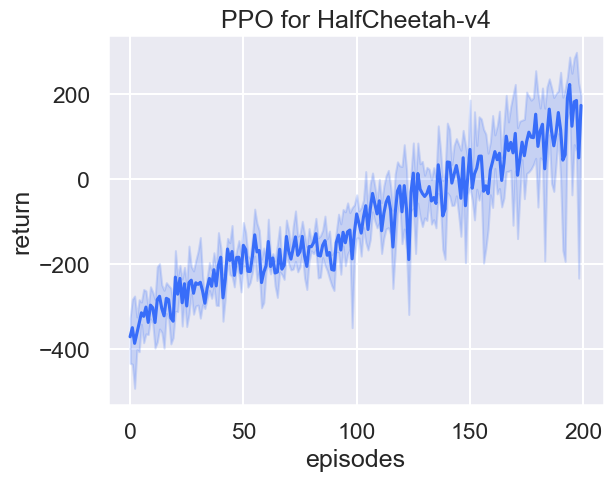

In [81]:
df1 = pd.DataFrame(returns_over_seeds).melt()
df1.rename(columns={"variable": "episodes", "value": "return"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="return", data=df1).set(title="PPO for HalfCheetah-v4")
# plt.show()

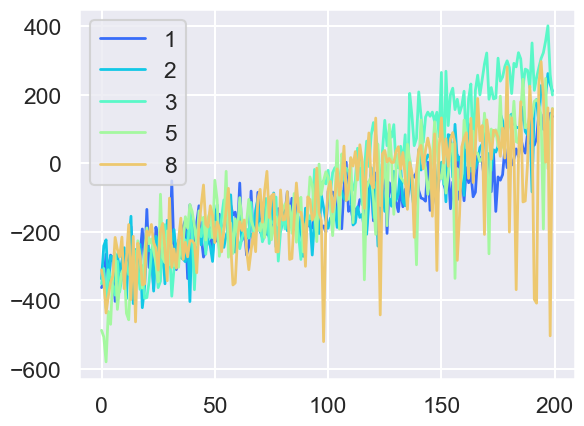

In [82]:
for i in range(5):
    plt.plot(returns_over_seeds[i], label=[1,2,3,5,8][i], linewidth=2)
plt.legend()    

# Extra functions

In [77]:
def eval_(env_name, agent, n_trajs=5):
    env = gym.make(env_name)
    returns = []
    for i in range(n_trajs):
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)
        
        ep_return = 0
        obs, info = env.reset(seed=i)
        
        for step in range(1000):
            action = agent.get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward
            done = terminated or truncated
            
            if done:
                returns.append(ep_return)
                break
    env.close()   
    
    return np.array(returns)



def render_(env_name, agent, seed=None):
    env = gym.make(env_name, render_mode='human')
    obs, info = env.reset(seed=seed)
    returns = 0
    for i in range(1000):
        # env.render()
        action = agent.get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, reward, terminated, truncated, _ = env.step(action)
        returns += reward
        done = terminated or truncated
#         print(i, terminated, truncated)
        if done:
            print(returns)
            break
    env.close()

In [78]:
eval_(env_name, ppo_agent)

array([351.87559278, 285.97761815, 379.37942727, 375.37768904,
       258.12870054])

In [79]:
render_(env_name, ppo_agent)

330.65220272662293
